[Epoch 10] Loss: 0.13764
[Epoch 20] Loss: 0.13700
[Epoch 30] Loss: 0.13473
[Epoch 40] Loss: 0.13173
[Epoch 50] Loss: 0.12918

📊 Final Accuracy: 0.2590
📊 Final F1 Score : 0.2364


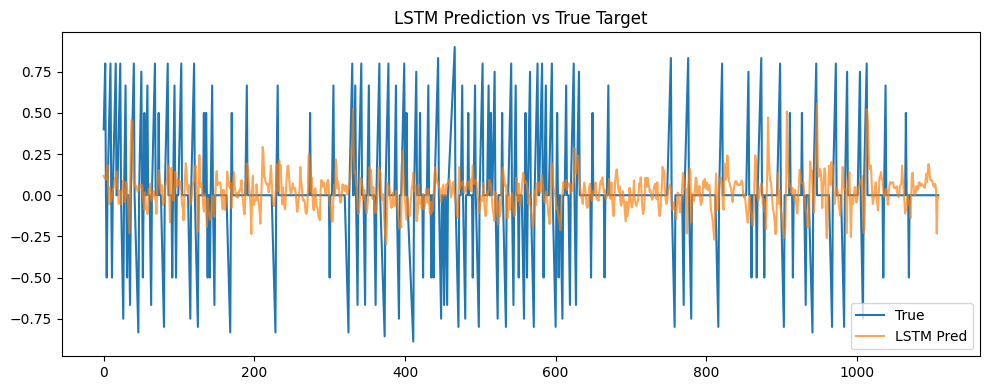

In [1]:
import os
import numpy as np
import pandas as pd
import ast
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# ─── 1) 최적화된 지표 파라미터 로딩 ─────────────────────────────────────
def load_selected_indicators(path, ticker):
    df = pd.read_csv(path)
    df = df[df['Ticker'] == ticker]

    if not df['Sharpe_Improved'].any() and not df['MDD_Improved'].any():
        print(f"⚠️  {ticker}: Sharpe & MDD 개선 없음 → 경험적 파라미터 사용")
        return {
            'sma': [20],
            'ema': [10],
            'rsi': [14, 30],
            'macd': [12, 26, 9],
            'bb': [20, 2]
        }

    selected_indicators = {}
    for _, row in df.iterrows():
        if row['Use'] == 1:
            params_str = row['Params_Opt'] if pd.notnull(row['Params_Opt']) else row['Params_Emp']
            try:
                params = ast.literal_eval(params_str)
            except (ValueError, SyntaxError):
                continue
            selected_indicators[row['Indicator'].lower()] = params

    return selected_indicators

# ─── 2) 기술적 지표 시그널 생성 ──────────────────────────────────────
def calc_signals(df, params):
    close = df['Close']
    signals = pd.DataFrame(index=df.index)

    if 'sma' in params:
        sma = close.rolling(params['sma'][0]).mean()
        signals['sma'] = np.where(close > sma, -1, 1)

    if 'ema' in params:
        ema = close.ewm(span=params['ema'][0], adjust=False).mean()
        signals['ema'] = np.where(close > ema, -1, 1)

    if 'rsi' in params:
        w, lo = params['rsi']
        delta = close.diff()
        up = delta.clip(lower=0).rolling(w).mean()
        down = -delta.clip(upper=0).rolling(w).mean()
        rsi = 100 - 100 / (1 + up / down)
        sig = pd.Series(0, index=df.index)
        sig[rsi < lo] = -1
        sig[rsi > 100 - lo] = 1
        signals['rsi'] = sig.values

    if 'macd' in params:
        f, s, sl = params['macd']
        macd_line = close.ewm(span=f, adjust=False).mean() - close.ewm(span=s, adjust=False).mean()
        macd_sig = macd_line.ewm(span=sl, adjust=False).mean()
        cross = macd_line - macd_sig
        sig = pd.Series(0, index=df.index)
        sig[(cross.shift(1) < 0) & (cross > 0)] = -1
        sig[(cross.shift(1) > 0) & (cross < 0)] = 1
        signals['macd'] = sig.values

    if 'bb' in params:
        w, ns = params['bb']
        ma = close.rolling(w).mean()
        std = close.rolling(w).std()
        upper = ma + ns * std
        lower = ma - ns * std
        sig = pd.Series(0, index=df.index)
        sig[close < lower] = -1
        sig[close > upper] = 1
        signals['bb'] = sig.values

    signals.fillna(0, inplace=True)
    return signals

# ─── 3) LSTM 모델 정의 ─────────────────────────────────────────────
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out.squeeze()

# ─── 4) 시퀀스 데이터 생성 ───────────────────────────────────────
def create_sequences(X, y, seq_len=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

# ─── 5) 학습 및 평가 ─────────────────────────────────────────────
def train_lstm(X, y, seq_len=10, epochs=50, batch_size=32, lr=1e-3):
    X_seq, y_seq = create_sequences(X, y, seq_len)

    split = int(0.7 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t  = torch.tensor(X_test, dtype=torch.float32)
    y_test_t  = torch.tensor(y_test, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)

    model = LSTMModel(input_size=X.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1) % 10 == 0:
            print(f"[Epoch {epoch+1}] Loss: {epoch_loss/len(train_loader):.5f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t).numpy()

    min_len = min(len(y_test), len(y_pred))
    true_dir = np.sign(y_test[:min_len][1:] - y_test[:min_len][:-1])
    pred_dir = np.sign(y_pred[:min_len][1:] - y_pred[:min_len][:-1])

    acc = accuracy_score(true_dir, pred_dir)
    f1 = f1_score(true_dir, pred_dir, average='macro')

    print(f"\n📊 Final Accuracy: {acc:.4f}")
    print(f"📊 Final F1 Score : {f1:.4f}")

    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(min_len), y_test[:min_len], label='True')
    plt.plot(np.arange(min_len), y_pred[:min_len], label='LSTM Pred', alpha=0.7)
    plt.title("LSTM Prediction vs True Target")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ─── 6) main 함수 ───────────────────────────────────────────────
if __name__ == "__main__":
    ticker = 'AAPL'
    proc_dir = '/content/drive/MyDrive/시계열/data/preprocessed'
    targ_dir = '/content/drive/MyDrive/시계열/data/target'
    opt_path = '/content/drive/MyDrive/시계열/reports/optimization_results.csv'

    df_price = pd.read_csv(f'{proc_dir}/{ticker}_processed.csv', parse_dates=['Date'], index_col='Date')
    df_targ  = pd.read_csv(f'{targ_dir}/{ticker}_target.csv', parse_dates=['Date'], index_col='Date')
    df_targ['Target'] = df_targ['triangular_target']

    selected_params = load_selected_indicators(opt_path, ticker)
    signals = calc_signals(df_price, selected_params).values
    y = df_targ['Target'].values

    train_lstm(signals, y, seq_len=10, epochs=50, batch_size=32, lr=1e-3)


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.5/585.5 kB 34.0 MB/s eta 0:00:00


[I 2025-06-20 08:02:48,576] A new study created in memory with name: no-name-bcb6a646-606c-496e-b05a-69a078e993dd
/tmp/ipython-input-3-1323194281.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-06-20 08:04:24,321] Trial 0 finished with value: 0.2649262310108281 and parameters: {'hidden_size': 154, 'num_layers': 3, 'lr': 5.3481580823815833e-05, 'seq_len': 10}. Best is trial 0 with value: 0.2649262310108281.
/tmp/ipython-input-3-1323194281.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-06-20 08:05:13,325] Trial 1 finished with value: 0.26046050559363526


✨ Best trial:
{'hidden_size': 69, 'num_layers': 1, 'lr': 0.0007311636040992023, 'seq_len': 8}
재학습 중...

✅ 최종 Accuracy: 0.2669
✅ 최종 F1 Score : 0.2417


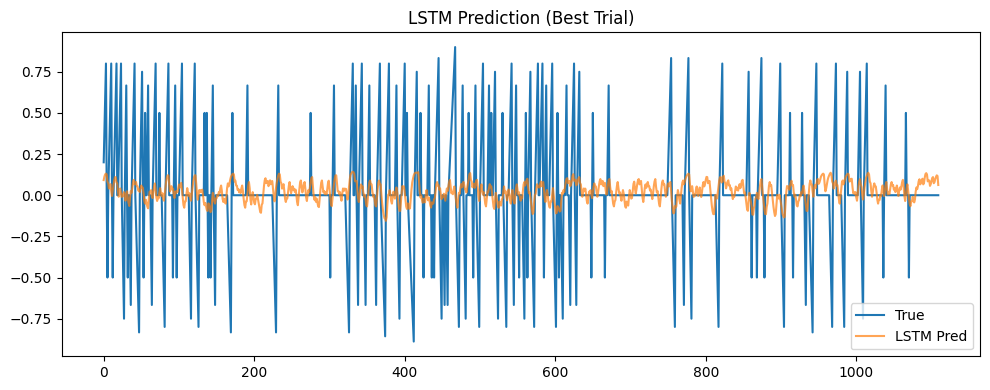

In [3]:
import optuna
from functools import partial

def objective(trial, X, y):
    # 탐색할 하이퍼파라미터
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    seq_len = trial.suggest_int("seq_len", 5, 20)

    # 시퀀스 생성
    X_seq, y_seq = create_sequences(X, y, seq_len)

    # Train/Validation Split
    split = int(0.7 * len(X_seq))
    X_train, X_val = X_seq[:split], X_seq[split:]
    y_train, y_val = y_seq[:split], y_seq[split:]

    # Tensor 변환
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32)

    # 모델 초기화
    model = LSTMModel(input_size=X.shape[1], hidden_size=hidden_size, num_layers=num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 학습
    for epoch in range(30):  # 고정된 epoch 수
        model.train()
        optimizer.zero_grad()
        output = model(X_train_t)
        loss = criterion(output, y_train_t)
        loss.backward()
        optimizer.step()

    # 예측
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_t).numpy()
        y_val_np = y_val_t.numpy()

    # 방향성 평가
    min_len = min(len(y_val_np), len(y_pred))
    true_dir = np.sign(y_val_np[:min_len][1:] - y_val_np[:min_len][:-1])
    pred_dir = np.sign(y_pred[:min_len][1:] - y_pred[:min_len][:-1])
    f1 = f1_score(true_dir, pred_dir, average='macro')

    return f1

if __name__ == "__main__":
    # 기존과 동일한 데이터 처리
    ticker = 'AAPL'
    proc_dir = '/content/drive/MyDrive/시계열/data/preprocessed'
    targ_dir = '/content/drive/MyDrive/시계열/data/target'
    opt_path = '/content/drive/MyDrive/시계열/reports/optimization_results.csv'

    df_price = pd.read_csv(f'{proc_dir}/{ticker}_processed.csv', parse_dates=['Date'], index_col='Date')
    df_targ  = pd.read_csv(f'{targ_dir}/{ticker}_target.csv', parse_dates=['Date'], index_col='Date')
    df_targ['Target'] = df_targ['triangular_target']

    selected_params = load_selected_indicators(opt_path, ticker)
    signals = calc_signals(df_price, selected_params).values
    y = df_targ['Target'].values

    # Optuna 수행
    study = optuna.create_study(direction='maximize')
    study.optimize(partial(objective, X=signals, y=y), n_trials=50)

    print("\n✨ Best trial:")
    print(study.best_trial.params)

    best = study.best_trial.params
    print("재학습 중...")

    # 시퀀스 재생성
    X_seq, y_seq = create_sequences(signals, y, seq_len=best['seq_len'])
    split = int(0.7 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t  = torch.tensor(X_test, dtype=torch.float32)
    y_test_t  = torch.tensor(y_test, dtype=torch.float32)

    model = LSTMModel(input_size=signals.shape[1], hidden_size=best['hidden_size'], num_layers=best['num_layers'])
    optimizer = torch.optim.Adam(model.parameters(), lr=best['lr'])
    criterion = nn.MSELoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_t)
        loss = criterion(output, y_train_t)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_t).numpy()
        y_test_np = y_test_t.numpy()

    min_len = min(len(y_test_np), len(y_pred))
    true_dir = np.sign(y_test_np[:min_len][1:] - y_test_np[:min_len][:-1])
    pred_dir = np.sign(y_pred[:min_len][1:] - y_pred[:min_len][:-1])
    acc = accuracy_score(true_dir, pred_dir)
    f1 = f1_score(true_dir, pred_dir, average='macro')
    print(f"\n✅ 최종 Accuracy: {acc:.4f}")
    print(f"✅ 최종 F1 Score : {f1:.4f}")

    # 시각화
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(min_len), y_test_np[:min_len], label='True')
    plt.plot(np.arange(min_len), y_pred[:min_len], label='LSTM Pred', alpha=0.7)
    plt.title("LSTM Prediction (Best Trial)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [4]:
import numpy as np
import pandas as pd

def backtest_performance(pred_signal, close_prices, transaction_cost=0.001):
    """
    pred_signal: np.array of {-1, 0, 1}
    close_prices: np.array of close prices (same length)
    """
    pred_signal = np.array(pred_signal)
    close_prices = np.array(close_prices)

    # 수익률 계산
    returns = np.diff(close_prices) / close_prices[:-1]
    signal = pred_signal[:-1]  # 다음 날 수익률에 오늘 시그널 적용
    strat_ret = signal * returns - transaction_cost * np.abs(np.diff(signal, prepend=0))

    # 누적 수익률
    cum_ret = np.cumprod(1 + strat_ret) - 1

    # 샤프지수 (연율화 기준 가정: 252 거래일)
    excess_ret = strat_ret - 0.0001  # 무위험 수익률 대체값
    sharpe = np.mean(excess_ret) / (np.std(excess_ret) + 1e-8) * np.sqrt(252)

    # MDD
    cum_val = np.cumprod(1 + strat_ret)
    peak = np.maximum.accumulate(cum_val)
    drawdown = (cum_val - peak) / peak
    mdd = np.min(drawdown)

    return {
        "Cumulative Return": cum_ret[-1],
        "Sharpe Ratio": sharpe,
        "MDD": mdd
    }

def buy_hold_performance(close_prices):
    returns = np.diff(close_prices) / close_prices[:-1]
    strat_ret = returns  # 항상 보유
    cum_ret = np.cumprod(1 + strat_ret) - 1
    sharpe = np.mean(strat_ret) / (np.std(strat_ret) + 1e-8) * np.sqrt(252)

    cum_val = np.cumprod(1 + strat_ret)
    peak = np.maximum.accumulate(cum_val)
    drawdown = (cum_val - peak) / peak
    mdd = np.min(drawdown)

    return {
        "Cumulative Return": cum_ret[-1],
        "Sharpe Ratio": sharpe,
        "MDD": mdd
    }

# 신호 생성: 예측 수익률 > 0 → 매수, < 0 → 매도
pred_signal = np.sign(y_pred[:min_len])  # 예측 기반 신호
close = df_price['Close'].values[-len(y_test):]  # 예측 구간의 종가

bt_lstm = backtest_performance(pred_signal, close[:min_len])
bt_bnh  = buy_hold_performance(close[:min_len])

print("\n📈 [LSTM 전략]")
for k, v in bt_lstm.items():
    print(f"{k}: {v:.4f}")

print("\n📊 [Buy & Hold 전략]")
for k, v in bt_bnh.items():
    print(f"{k}: {v:.4f}")



📈 [LSTM 전략]
Cumulative Return: -0.2513
Sharpe Ratio: -0.1628
MDD: -0.5308

📊 [Buy & Hold 전략]
Cumulative Return: 1.4204
Sharpe Ratio: 0.8346
MDD: -0.3194


/tmp/ipython-input-6-2554105769.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-6-2554105769.py:34: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128188 (\N{BRIEFCASE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


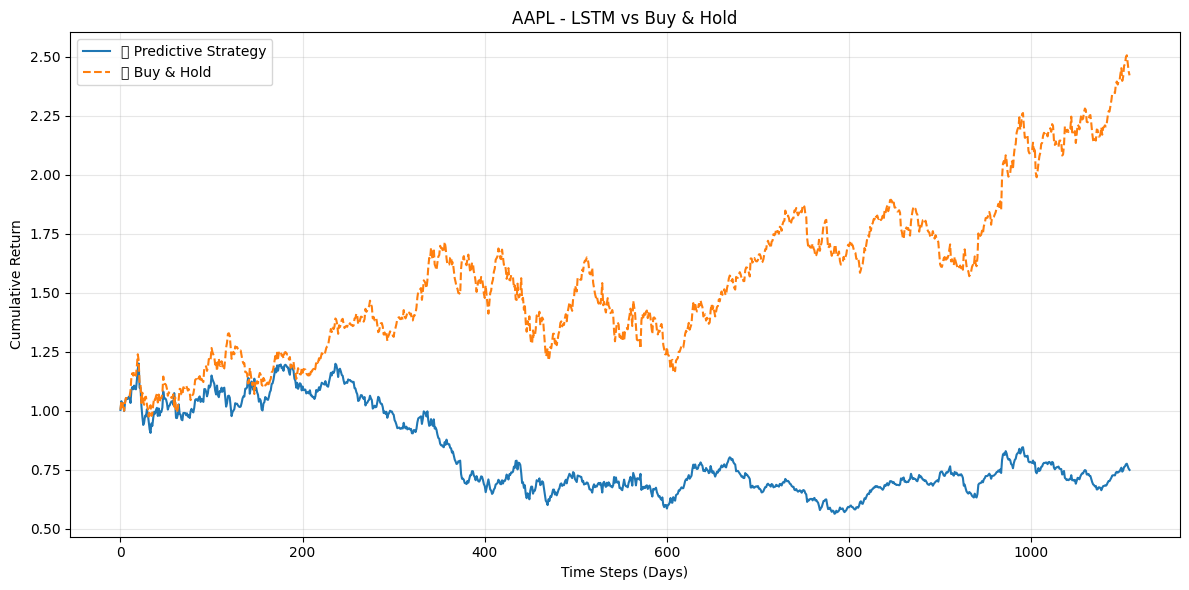

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cumulative_returns(pred_signal, close_prices, title="Cumulative Return Comparison", transaction_cost=0.001):
    """
    pred_signal: 예측 시그널 (np.array), {-1, 0, 1}
    close_prices: 종가 시계열 (np.array)
    """

    pred_signal = np.array(pred_signal)
    close_prices = np.array(close_prices)

    # 수익률 계산
    returns = np.diff(close_prices) / close_prices[:-1]

    # 예측 전략 수익률
    signal = pred_signal[:-1]
    strategy_returns = signal * returns - transaction_cost * np.abs(np.diff(signal, prepend=0))
    cumulative_strategy = np.cumprod(1 + strategy_returns)

    # Buy & Hold 수익률
    buy_hold_returns = returns
    cumulative_bnh = np.cumprod(1 + buy_hold_returns)

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_strategy, label='📈 Predictive Strategy')
    plt.plot(cumulative_bnh, label='💼 Buy & Hold', linestyle='--')
    plt.title(title)
    plt.xlabel("Time Steps (Days)")
    plt.ylabel("Cumulative Return")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 예측 결과로 시그널 생성
pred_signal = np.sign(y_pred[:min_len])
close = df_price['Close'].values[-len(y_test):]  # test 시점 종가
close_cut = close[:min_len]

# 시각화 호출
plot_cumulative_returns(pred_signal, close_cut, title=f"{ticker} - LSTM vs Buy & Hold")
